# Feature Extraction using Convolutional Neural Networks
[GitHub Tutorial:CIFAR 10 feature extraction using pretrained convolutional depp neural networks from keras library](https://github.com/rnoxy/cifar10-cnn/blob/master/Feature_extraction_using_keras.ipynb)

In [1]:
#Github code
network_names = [ 'incv3', 'resnet50', 'vgg16', 'vgg19' ]

print("Available networks = ", network_names)
cnnid = int( input("Please choose the CNN network [0-{n}]: ".format(n=len(network_names)-1)) )
selected_network = network_names[cnnid]
print("Selected network: ", selected_network)

Available networks =  ['incv3', 'resnet50', 'vgg16', 'vgg19']
Please choose the CNN network [0-3]: 3
Selected network:  vgg19


In [2]:
 pip install myutils

  Created wheel for myutils: filename=myutils-0.0.21-py3-none-any.whl size=1363 sha256=8ac8b6c6e23dd2cabb3c7b4b820c6c762847c0049ac9a6abe82208a8bf232a8a
  Stored in directory: /root/.cache/pip/wheels/8e/89/9f/ab7f23dcc9ba30d64a298bcfc29c4e7e9ec59110ddc69aac12
Successfully built myutils


In [3]:
#github
import time
import myutils
import numpy as np
import tensorflow.compat.v1 as tf
tf.compat.v1.disable_v2_behavior()
from keras.layers import Input, Dense, AveragePooling2D, GlobalAveragePooling2D
from keras import backend as K

Instructions for updating:
non-resource variables are not supported in the long term


## Load Mnist data

11501568/11490434 [==============================] - 0s 0us/step
(60000, 28, 28, 3) (60000,) (10000, 28, 28, 3) (10000,)


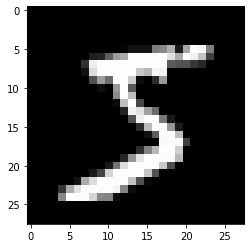

In [4]:
#github
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train=np.stack((X_train,X_train,X_train), axis=3)
X_test=np.stack((X_test,X_test,X_test), axis=3)
n_training = X_train.shape[0]
n_testing = X_test.shape[0]

y_train = y_train.flatten()
y_test  = y_test.flatten()

print( X_train.shape, y_train.shape,  X_test.shape, y_test.shape )

from matplotlib import pyplot as plt
plt.imshow( X_train[0]  )
plt.show()

## Create model

In [5]:
#github
from keras.models import Model
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet     import ResNet50
from keras.applications.vgg16        import VGG16
from keras.applications.vgg19        import VGG19

input_shape = {
    'incv3'   : (299,299,3),
    'resnet50': (224,224,3),
    'vgg16'   : (224,224,3),
    'vgg19'   : (224,224,3)
}[selected_network]

def create_model_incv3():
    tf_input = Input(shape=input_shape)
    model = InceptionV3(input_tensor=tf_input, weights='imagenet', include_top=False)
    output_pooled = AveragePooling2D((8, 8), strides=(8, 8))(model.output)
    return Model(model.input, output_pooled)

def create_model_resnet50():
    tf_input = Input(shape=input_shape)
    return ResNet50(input_tensor=tf_input, include_top=False)

def create_model_vgg16():
    tf_input = Input(shape=input_shape)
    model = VGG16(input_tensor=tf_input, include_top=False)
    output_pooled = AveragePooling2D((7, 7))(model.output)
    return Model(model.input, output_pooled )

def create_model_vgg19():
    tf_input = Input(shape=input_shape)
    model = VGG19(input_tensor=tf_input, include_top=False)
    output_pooled = AveragePooling2D((7, 7))(model.output)
    return Model(model.input, output_pooled )

create_model = {
    'incv3'    : create_model_incv3,
    'resnet50' : create_model_resnet50,
    'vgg16'    : create_model_vgg16,
    'vgg19'    : create_model_vgg19
}[selected_network]

## Data generator for tensorflow

[Tensorflow 1 to 2](https://stackoverflow.com/questions/60966376/best-practice-to-write-code-compatible-to-both-tensorflow-1-and-2)

In [6]:
#github
# tensorflow placeholder for batch of images from CIFAR10 dataset
batch_of_images_placeholder = tf.placeholder("uint8", (None, 28, 28,3))

batch_size = {
    'incv3'    : 16,
    'resnet50' : 16,
    'vgg16'    : 16,
    'vgg19'    : 16
}[selected_network]

# Inception default size is 299x299
tf_resize_op = tf.image.resize(batch_of_images_placeholder, (input_shape[:2]), method='bilinear')

In [7]:
#github
# data generator for tensorflow session
from keras.applications.inception_v3 import preprocess_input as incv3_preprocess_input
from keras.applications.resnet     import preprocess_input as resnet50_preprocess_input
from keras.applications.vgg16        import preprocess_input as vgg16_preprocess_input
from keras.applications.vgg19        import preprocess_input as vgg19_preprocess_input

preprocess_input = {
    'incv3'   : incv3_preprocess_input,
    'resnet50': resnet50_preprocess_input,
    'vgg16'   : vgg16_preprocess_input,
    'vgg19'   : vgg19_preprocess_input
}[selected_network]

def data_generator(sess,data,labels):
    def generator():
        start = 0
        end = start + batch_size
        n = data.shape[0]
        while True:
            batch_of_images_resized = sess.run(tf_resize_op, {batch_of_images_placeholder: data[start:end]})
            batch_of_images__preprocessed = preprocess_input(batch_of_images_resized)
            batch_of_labels = labels[start:end]
            start += batch_size
            end   += batch_size
            if start >= n:
                start = 0
                end = batch_size
            yield (batch_of_images__preprocessed, batch_of_labels)
    return generator

## Feature extraction

In [8]:
with tf.Session() as sess:
    # setting tensorflow session to Keras
    K.set_session(sess)
    # setting phase to training
    K.set_learning_phase(1)  # 0 - test,  1 - train

    model = create_model()

    data_train_gen = data_generator(sess, X_train, y_train)
    ftrs_training = model.predict_generator(data_train_gen(), n_training/batch_size, verbose=1)

    data_test_gen = data_generator(sess, X_test, y_test)
    ftrs_testing = model.predict_generator(data_test_gen(), n_testing/batch_size, verbose=1)

/usr/local/lib/python3.7/dist-packages/keras/backend.py:414: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


80150528/80134624 [==============================] - 0s 0us/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


In [9]:
#github
features_training = np.array( [ftrs_training[i].flatten() for i in range(n_training)] )
features_testing  = np.array( [ftrs_testing[i].flatten()  for i in range(n_testing )] )

#np.savez_compressed("features/CIFAR10_{}-keras_features.npz".format(selected_network),features_training=features_training,features_testing=features_testing,labels_training=y_train,labels_testing=y_test)

In [ ]:
#github
features_training.shape, features_testing.shape

((60000, 512), (10000, 512))

In [ ]:
#github
print('Ten first features of X_train[0] (see figure above, with the frog)')
features_training[0][0:10]

Ten first features of X_train[0] (see figure above, with the frog)


array([4.984349  , 2.1439927 , 0.7077353 , 0.1357666 , 0.10525085,
       1.9851164 , 0.6462987 , 1.8137113 , 2.987951  , 0.        ],
      dtype=float32)

## Feature visualization

### Feature analysis (using PCA)

In [10]:
#github
import numpy as np
import myutils

#data = np.load("features/CIFAR10_{}-keras_features.npz".format(selected_network))

X_training = features_training
y_training = y_train

X_testing = features_testing
y_testing = y_test

# data_training, data_testing = myutils.load_CIFAR_dataset(shuffle=False)
# assert( (np.array( [data_training[i][1] for i in range(len(data_training))] ) == y_training).all() )
# assert( (np.array( [data_testing[i][1] for i in range(len(data_testing))] ) == y_testing).all() )
print( 'X_training size = {}'.format(X_training.shape))

X_training size = (60000, 512)


In [11]:
#github
from sklearn import decomposition

pca = decomposition.PCA(n_components=500)
pca.fit(X_training)

PCA(n_components=500)

In [12]:
#github
X = pca.transform(X_training)

In [ ]:
#github
X.shape

(60000, 500)

# Classifier

In [13]:
from sklearn.preprocessing import LabelBinarizer
#custom code
Y_train=LabelBinarizer().fit_transform(y_training)
Y_test=LabelBinarizer().fit_transform(y_testing)

In [14]:
pip install scikit-eLCS

     |████████████████████████████████| 258 kB 7.4 MB/s 
  Created wheel for scikit-eLCS: filename=scikit_eLCS-1.2.3-py3-none-any.whl size=38593 sha256=f37004454d6043c9faf974dd880b3b47b588f1be1a90df136770c8a9cfc2bc45
  Stored in directory: /root/.cache/pip/wheels/97/97/69/dcb4cf87c2671813c166955429f3fdfff9ece959980c328bfb
Successfully built scikit-eLCS


In [15]:
from skeLCS import eLCS
model = eLCS(N=100000, learning_iterations = 10000,nu = 10,selection_method='tournament',track_accuracy_while_fit=True)
trainedModel = model.fit(X,y_training)

In [16]:
pca.fit(X_testing)
X_t = pca.transform(X_testing)

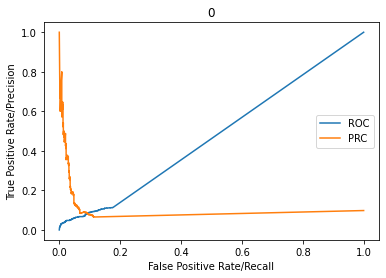

PRC AUC:0.09863933508625836
ROC AUC:0.47213148785012893


In [17]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt

probs = trainedModel.predict_proba(X_t)
fpr1, tpr1, thresholds1 = roc_curve(Y_test[:,0], probs[:,0])
prec1, recall1, thresholds1 = precision_recall_curve(Y_test[:,0], probs[:,0])

plt.plot(fpr1,tpr1,label="ROC")
plt.plot(recall1,prec1,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('0')
plt.show()

print("PRC AUC:" + str(auc(recall1, prec1)))
print("ROC AUC:" + str(auc(fpr1, tpr1)))

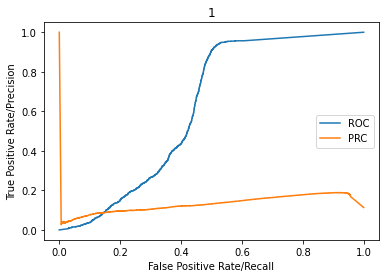

PRC AUC:0.1326546965973809
ROC AUC:0.6186142604063398


In [18]:
fpr2, tpr2, thresholds2 = roc_curve(Y_test[:,1], probs[:, 1])
prec2, recall2, thresholds2 = precision_recall_curve(Y_test[:,1], probs[:, 1])

plt.plot(fpr2,tpr2,label="ROC")
plt.plot(recall2,prec2,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('1')
plt.show()

print("PRC AUC:" + str(auc(recall2, prec2)))
print("ROC AUC:" + str(auc(fpr2, tpr2)))

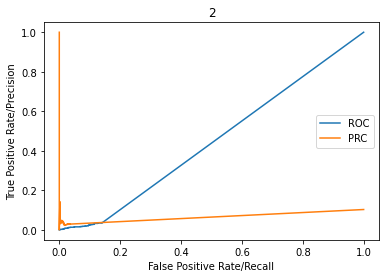

PRC AUC:0.06524753624367564
ROC AUC:0.4476901398771861


In [19]:
fpr3, tpr3, thresholds3 = roc_curve(Y_test[:,2], probs[:, 2])
prec3, recall3, thresholds3 = precision_recall_curve(Y_test[:,2], probs[:, 2])

plt.plot(fpr3,tpr3,label="ROC")
plt.plot(recall3,prec3,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('2')
plt.show()

print("PRC AUC:" + str(auc(recall3, prec3)))
print("ROC AUC:" + str(auc(fpr3, tpr3)))

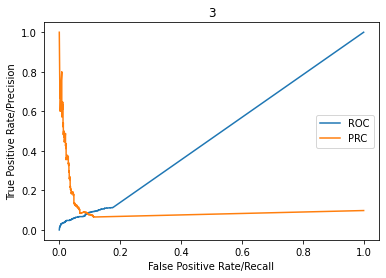

PRC AUC:0.16621141353143834
ROC AUC:0.6164168658245136


In [20]:
fpr4, tpr4, thresholds4 = roc_curve(Y_test[:,3], probs[:, 3])
prec4, recall4, thresholds4 = precision_recall_curve(Y_test[:,3], probs[:, 3])

plt.plot(fpr1,tpr1,label="ROC")
plt.plot(recall1,prec1,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('3')
plt.show()

print("PRC AUC:" + str(auc(recall4, prec4)))
print("ROC AUC:" + str(auc(fpr4, tpr4)))

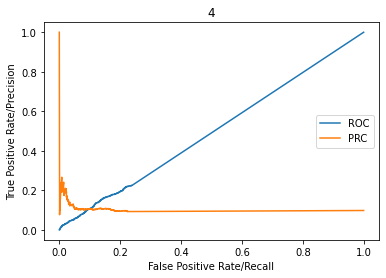

PRC AUC:0.10067564727225545
ROC AUC:0.4959312535824481


In [21]:
fpr5, tpr5, thresholds5 = roc_curve(Y_test[:,4], probs[:, 4])
prec5, recall5, thresholds5 = precision_recall_curve(Y_test[:,4], probs[:, 4])

plt.plot(fpr5,tpr5,label="ROC")
plt.plot(recall5,prec5,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('4')
plt.show()

print("PRC AUC:" + str(auc(recall5, prec5)))
print("ROC AUC:" + str(auc(fpr5, tpr5)))

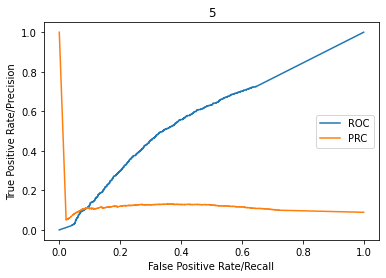

PRC AUC:0.11966519672360257
ROC AUC:0.5801325179066942


In [22]:
fpr6, tpr6, thresholds6 = roc_curve(Y_test[:,5], probs[:, 5])
prec6, recall6, thresholds6 = precision_recall_curve(Y_test[:,5], probs[:, 5])

plt.plot(fpr6,tpr6,label="ROC")
plt.plot(recall6,prec6,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('5')
plt.show()

print("PRC AUC:" + str(auc(recall6, prec6)))
print("ROC AUC:" + str(auc(fpr6, tpr6)))

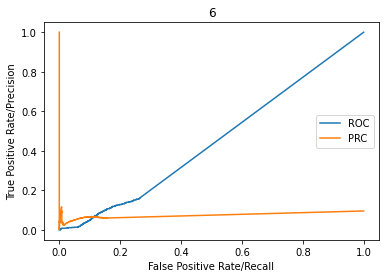

PRC AUC:0.07477455940348832
ROC AUC:0.44787754570528904


In [23]:
fpr7, tpr7, thresholds7 = roc_curve(Y_test[:,6], probs[:, 6])
prec7, recall7, thresholds7 = precision_recall_curve(Y_test[:,6], probs[:, 6])

plt.plot(fpr7,tpr7,label="ROC")
plt.plot(recall7,prec7,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('6')
plt.show()

print("PRC AUC:" + str(auc(recall7, prec7)))
print("ROC AUC:" + str(auc(fpr7, tpr7)))

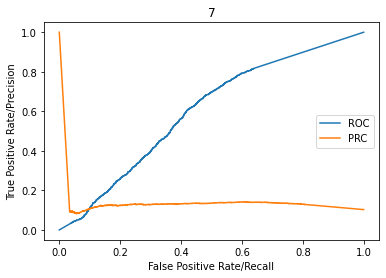

PRC AUC:0.14059537372829806
ROC AUC:0.6013464284041489


In [24]:
fpr8, tpr8, thresholds8 = roc_curve(Y_test[:,7], probs[:, 7])
prec8, recall8, thresholds8 = precision_recall_curve(Y_test[:,7], probs[:, 7])

plt.plot(fpr8,tpr8,label="ROC")
plt.plot(recall8,prec8,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('7')
plt.show()

print("PRC AUC:" + str(auc(recall8, prec8)))
print("ROC AUC:" + str(auc(fpr8, tpr8)))

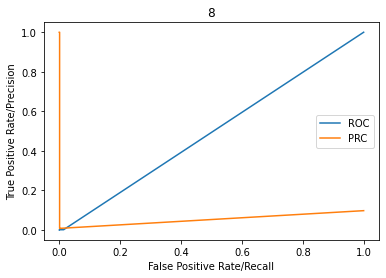

PRC AUC:0.05354868360313898
ROC AUC:0.493429999849852


In [25]:
fpr9, tpr9, thresholds9 = roc_curve(Y_test[:,8], probs[:, 8])
prec9, recall9, thresholds9 = precision_recall_curve(Y_test[:,8], probs[:, 8])

plt.plot(fpr9,tpr9,label="ROC")
plt.plot(recall9,prec9,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('8')
plt.show()

print("PRC AUC:" + str(auc(recall9, prec9)))
print("ROC AUC:" + str(auc(fpr9, tpr9)))

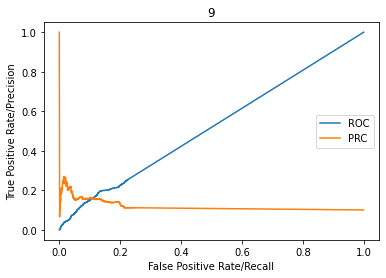

PRC AUC:0.11912834883731055
ROC AUC:0.5198484466186261


In [26]:
fpr10, tpr10, thresholds10 = roc_curve(Y_test[:,9], probs[:, 9])
prec10, recall10, thresholds10 = precision_recall_curve(Y_test[:,9], probs[:, 9])

plt.plot(fpr10,tpr10,label="ROC")
plt.plot(recall10,prec10,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('9')
plt.show()

print("PRC AUC:" + str(auc(recall10, prec10)))
print("ROC AUC:" + str(auc(fpr10, tpr10)))

In [33]:
Y_test[3]

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0])